# Compressive Sensing for Polynomial Approximations

<h4> By Nicholas Wong </h4>

In [1]:
%matplotlib inline
import sys
sys.path.append('../') 
from equadratures import *
import numpy as np
import scipy.stats as st

<h2> Background </h2>

Recall that in Effective-Quadratures, we approximate models using a linear combination of orthogonal polynomials:

$$ f(s) = \sum_{i=1}^{P} x_i \phi_i(s). $$

To find the polynomial coefficients $x_i$, we need to compute an integral:

$$ x_i = \int_S f(s) \phi_i(s) \rho(s) ds.$$

To numerically evaluate the integral, we often use quadrature rules or least squares, both of which require at least as many observations as the number of basis terms ($P$) as we use. As the number of input variables increases, $P$ increases rapidly. To reduce computational costs related to evaluating the model, we ask if we could afford to use fewer obervations than basis terms. This motivates the idea of compressive sensing (CS).

In CS, we assume that the solution we seek is sparse -- i.e. there are only a few non-zero coefficients and many coefficients near zero. If the solution is sufficiently sparse, it can be shown that the solution is guaranteed to be found with high probability using a number of observations that scales with the sparsity (number of non-zeros) of the solution instead of the number of basis terms. This permits us to solve for the coefficients using fewer observations than basis terms.

With this technique, we solve for the sparsest compatible coefficients given our observations. This is NP-hard, but we can implement this in polynomial time using the basis pursuit denoising algorithm:

\begin{align}
\text{minimize}\qquad &\left\lVert \mathbf{x} \right\rVert_1 \\
\text{subject to}\qquad &\left\lVert \mathbf{Ax - b} \right\rVert_2 \leq \eta,
\end{align}

where $\mathbf{A}$ is the Vendermonde-like matrix of polynomial term evaluations, $\mathbf{b}$ is a vector of model evaluations, and $\eta$ a positive constant representing the error we allow in our approximation. We have  implemented utilities for calculating coefficients using CS in Effective-Quadratures; based on the work of Tang and Iaccarino [1] and using the basis pursuit de-noising approaches in [2, 3].

<h2> Example </h2>

We demonstrate the capabilities of CS using a dataset generously provided by Rolls Royce plc. In this data, we measure the system efficiency of a fan using five blade design parameters, measured at five stations along the blade. This gives us 25 variables in total. We are given 548 observations in total. These are loaded in the arrays X and Y:

In [2]:
X = np.loadtxt("data/h_X.dat")
Y = np.loadtxt("data/h_Y.dat") 
print X.shape
print Y.shape

(548, 25)
(548,)


We fit a quadratic in 25 dimensions to the data using a total order basis set. 

In [3]:
N = X.shape[0]
p_order = 2
params = []
basis_orders = []

for i in range(25):
    params.append(Parameter(p_order, distribution = 'Custom', data = np.reshape(X[:,i], (N,))))
    basis_orders.append(p_order)

basis = Basis("total order", orders = basis_orders)

The number of basis terms we have is:

In [4]:
print basis.cardinality

351


Hence, for least squares (LS) we expect that at least 351 observations are required. However, as we shall demonstrate, we do not need so many for CS. We randomly pick 200 out of the 548 observations and attempt to recover the coefficients. That is, we randomly sample 200 rows out of X and Y:

In [5]:
num_obs = 200
chosen_points = np.random.choice(range(N), size = num_obs, replace = False)
X_red = X[chosen_points,:]
Y_red = Y[chosen_points]

We then initialize the polycs class, which automatically calculates the coefficients for us.

In [8]:
polycs = Polycs(params, basis, training_inputs = X_red, training_outputs = Y_red)

To verify that the coefficients we calculate are sensible, we verify the fit on data not used for training.

In [9]:
remaining_pts = np.delete(np.arange(N), chosen_points)
chosen_valid_pts = np.random.choice(remaining_pts, size = 30, replace = False)
        
x_eval = X[chosen_valid_pts]
y_eval = np.squeeze(np.asarray(polycs.evaluatePolyFit(x_eval)))
y_valid = Y[chosen_valid_pts].flatten()


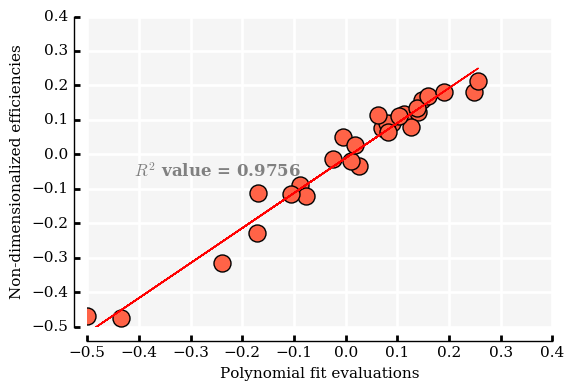

In [10]:
a,b,r,_,_ = st.linregress(y_eval.flatten(),y_valid.flatten())
r2 = "$R^2$ value = " + str(np.round(r**2, 4))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.scatter(y_eval, y_valid, s=150, c='tomato', marker='o')
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel('Polynomial fit evaluations')
plt.ylabel('Non-dimensionalized efficiencies')
plt.xlim([-0.5, 0.4])
plt.ylim([-0.5, 0.4])
yfit = [b + a * xi for xi in y_eval]
plt.plot(y_eval, yfit, 'r-')
plt.text(0.1, 0.5, r2 , horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=12, color='gray', weight='bold')
plt.show()

Indeed, CS provides a good approximation to the model. Why is this the case? We plot the log of the coefficients' magnitudes in descending order:

In [11]:
sorted_coeffs = sorted((np.log10(np.abs(polycs.coefficients))),reverse = True)

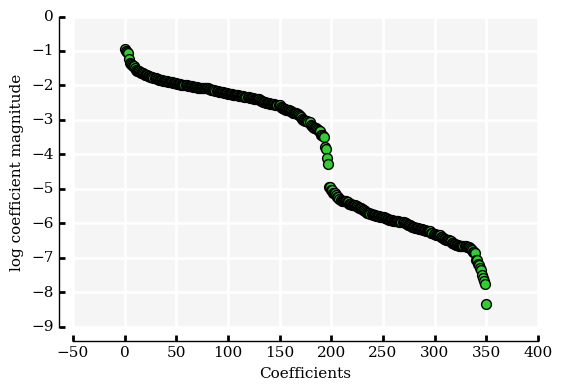

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.scatter(range(351),sorted_coeffs, s=50, c='limegreen', marker='o')
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel("Coefficients")
plt.ylabel("log coefficient magnitude")
plt.show()

Though we cannot say the solution is exactly sparse, it is approximately sparse, in a sense that a lot of the coefficients are close to zero. In other words, we have coefficient decay. The power in the CS algorithm lies in the fact that it can self-adjust to a suitable noise level in order to accommodate for different degrees of coefficient decay. With this, we are able to handle a much wider range of models using CS, provided we use a high enough degree polynomial.

<h3> References </h3> 

[1] Tang, G., Iaccarino, G. "Subsampled Gauss quadrature nodes for estimating polynomial chaos expansions." SIAM/ASA Journal on Uncertainty Quantification 2.1 (2014): 423-443.

[2] Chen, S. S., Donoho, D. L., and Saunders, M. A. "Atomic decomposition by basis pursuit." SIAM review 43.1 (2001): 129-159.

[3] Candès, E. J., Romberg, J., and Tao, T. "Robust uncertainty principles: Exact signal reconstruction from highly incomplete frequency information." IEEE Transactions on information theory 52.2 (2006): 489-509.